# Import

In [1]:
# importing the libraries
import pandas as pd
import numpy as np
import seaborn as sns
from itertools import chain

# for reading and displaying images
import matplotlib.pyplot as plt
from glob import glob

# for creating validation set
from sklearn.model_selection import train_test_split

# PyTorch libraries and modules
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as dset
from torch.utils.data import DataLoader

# models
from src.dataloader import *
from src.architectures.resnet import *
from src.architectures.levakov_96 import *
from src.architectures.inception import *
from src.architectures.dinsdale import *

from src.run import *

from torch.optim import *
import torch.optim as optim
from torchsummary import summary

# CAM
from PIL import Image
from matplotlib.pyplot import imshow

from medcam import medcam

# Setups

## Load Model

In [2]:
def load_model(model, verbose=True):
    
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print(f'Model {model.capitalize()} is selected.')

    if model == 'resnet':
        

        opt = Option()
        model = generate_model(model_depth=opt.model_depth,
                                    n_classes=opt.n_classes,
                                    n_input_channels=opt.n_input_channels,
                                    shortcut_type=opt.shortcut_type,
                                    conv1_t_size=opt.conv1_t_size,
                                    conv1_t_stride=opt.conv1_t_stride,
                                    no_max_pool=opt.no_max_pool,
                                    widen_factor=opt.resnet_widen_factor)

    elif model == 'levakov':
        model = Levakov(task_type='age')

    elif model == 'inception':
        model = Inception3()

    elif model == 'dinsdale':
        model = Dinsdale(1, 1, 2)

    else: return None

    model.to(device)
    if verbose:
        print(summary(model, input_size=(1, 96, 96, 96)))
    
    return model, device

model = 'resnet'
model, device = load_model(model)

Model Resnet is selected.
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1       [-1, 16, 96, 48, 48]           2,352
       BatchNorm3d-2       [-1, 16, 96, 48, 48]              32
              ReLU-3       [-1, 16, 96, 48, 48]               0
         MaxPool3d-4       [-1, 16, 48, 24, 24]               0
            Conv3d-5       [-1, 16, 48, 24, 24]           6,912
       BatchNorm3d-6       [-1, 16, 48, 24, 24]              32
              ReLU-7       [-1, 16, 48, 24, 24]               0
            Conv3d-8       [-1, 16, 48, 24, 24]           6,912
       BatchNorm3d-9       [-1, 16, 48, 24, 24]              32
             ReLU-10       [-1, 16, 48, 24, 24]               0
       BasicBlock-11       [-1, 16, 48, 24, 24]               0
           Conv3d-12       [-1, 32, 24, 12, 12]          13,824
      BatchNorm3d-13       [-1, 32, 24, 12, 12]              64
             

## Default Settings

Default Settings

In [3]:
model = torch.load('models/resnet_200_elastic_6.949.pth')

In [4]:
task_type = 'age' # no longer used.
resize = True
scheduler = False
epochs = range(200)
fold = None

from src.losses import RMSELoss

loss_fn = nn.MSELoss()
lamb = 0.0005
rmse_fn = RMSELoss()
mae_fn = nn.L1Loss()

# Make Inference (attention maps)

In [5]:
model = medcam.inject(model, output_dir="attention_maps/tmp/", save_maps=True, retain_graph=True, layer='layer4')
model, (tst_losses, tst_maes, tst_rmses), tst_preds = eval(model, True, None, fold, resize, device, 1,
                                                       loss_fn, mae_fn, rmse_fn,
                                                       [], [], [])

# Attention Maps

In [8]:
dset = MyDataset(task_type='age', test=True, augment=None, fold=None)
dataloader = DataLoader(dset, batch_size=1)

## Heatmap Viewer

In [95]:
def view_heatmap(idx=0, path=None, avg=False, show=True):
    
    if path is None:
        path = glob('./attention_maps/conv1/*.nii.gz')
        
    if avg:
        att = nib.load(path[0]).get_fdata()
        for maps in path[1:]:

            att += nib.load(maps).get_fdata()

        att /= len(path)
        title = 'Averaged Attention Map'
        
    else:
        att = nib.load(path[idx]).get_fdata()
        src = dset.data_files[idx].split('\\')[-1][:3]
        if src == 'rec': src = 'Oasis1'
        elif src == 'sub': src = 'Oasis3'
        
        title = f'Attention Map for Index {idx}, from {src}'
        
    if show:
        fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(17, 5))
        fig.suptitle(title)

        x, y, z = att.shape
        sns.heatmap(att[x//2, :, :], ax=axes[0])
        sns.heatmap(att[:, y//2, :], ax=axes[1])
        sns.heatmap(att[:, :, z//2], ax=axes[2])
        
    else:
        return att

## Attention maps from 1st Conv Layer(conv1)

./attention_maps/conv1/*.nii.gz

In [6]:
path = glob('./attention_maps/conv1/*.nii.gz')

In [ ]:
# view_heatmap(avg=True)

In [ ]:
# for idx in np.random.choice(range(len(path)), size=10):
#     view_heatmap(idx)

## Zero-ratios for attention maps

### Calculate Zero-ratios

In [70]:
ratios = []
for idx, file in enumerate(path):
    
    att = nib.load(file).get_fdata()
    zero = len(att[att == 0]) / (48 * 48 * 96) * 100
    data = dset.data_files[idx].split('\\')[-1]
    ratios.append((data, zero))

### and their Histograms from different source

In [72]:
ratios_sorted = sorted(ratios, key=(lambda x: x[0]))

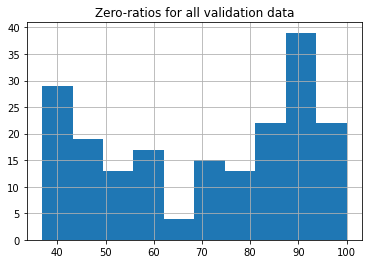

In [90]:
plt.title('Zero-ratios for all validation data')
plt.hist([_[1] for _ in ratios_sorted])
plt.grid()

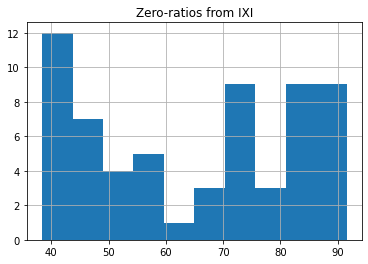

In [91]:
ratios_ixi = list(filter(lambda x: x[0][:3]=='IXI', ratios_sorted))
plt.title('Zero-ratios from IXI')
plt.hist([_[1] for _ in ratios_ixi])
plt.grid()

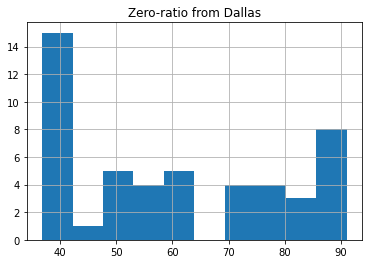

In [92]:
ratios_pal = list(filter(lambda x: x[0][:3]=='PAL', ratios_sorted))
plt.title('Zero-ratio from Dallas')
plt.hist([_[1] for _ in ratios_pal])
plt.grid()

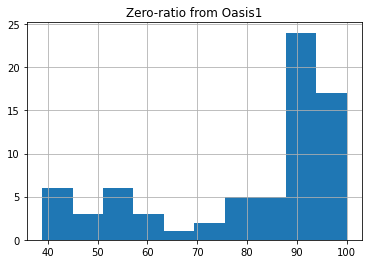

In [93]:
ratios_recon = list(filter(lambda x: x[0][:5]=='recon', ratios_sorted))
plt.title('Zero-ratio from Oasis1')
plt.hist([_[1] for _ in ratios_recon])
plt.grid()

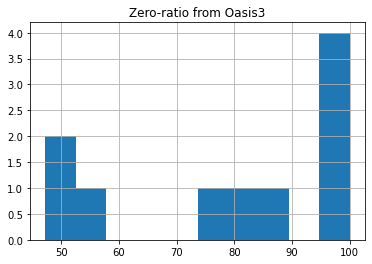

In [94]:
ratios_sub = list(filter(lambda x: x[0][:3]=='sub', ratios_sorted))
plt.title('Zero-ratio from Oasis3')
plt.hist([_[1] for _ in ratios_sub])
plt.grid()

## Original Source Quality Checking

In [9]:
from src.slice_viewer import *

../../brainmask_tlrc\sub-OAS30852_ses-d2307_run-04_T1w_tlrc.npy


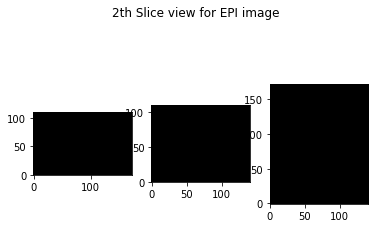

../../brainmask_tlrc\sub-OAS30960_ses-d0061_run-04_T1w_tlrc.npy


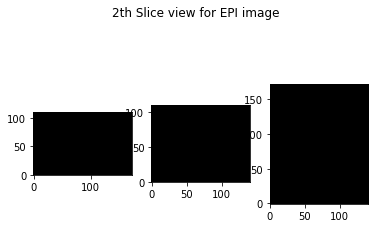

../../brainmask_tlrc\reconV6_OAS1_0002_MR1-brainmask_tlrc.npy


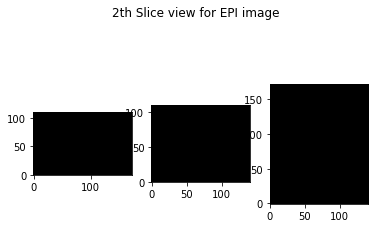

../../brainmask_tlrc\sub-OAS30249_ses-d0091_run-03_T1w_tlrc.npy


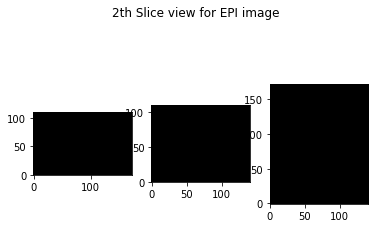

../../brainmask_tlrc\sub-OAS30936_ses-d5756_run-03_T1w_tlrc.npy


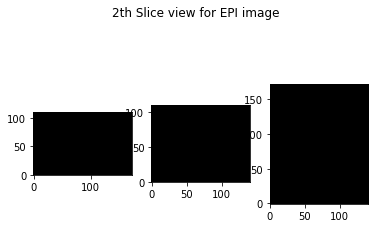

In [22]:
for idx in [68, 111, 112, 123, 139]:
    
    print(dset.data_files[idx])
    viewer = SliceViewer(dset.data_files[idx])
    viewer.triple_view()

../../brainmask_tlrc\sub-OAS30444_ses-d0001_run-04_T1w_tlrc.npy


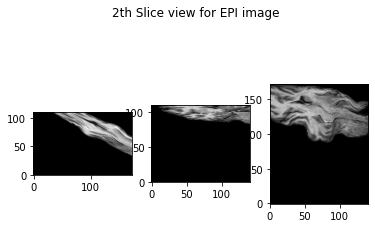

In [23]:
for idx in [13]:
    
    print(dset.data_files[idx])
    viewer = SliceViewer(dset.data_files[idx])
    viewer.triple_view()

../../brainmask_tlrc\PAL221_mpr_wave1_orig-brainmask_tlrc.npy


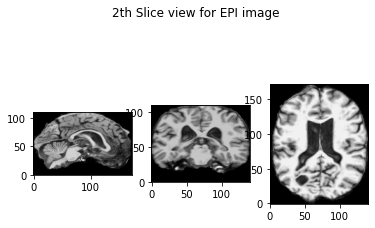

../../brainmask_tlrc\IXI415-Guys-0942-T1-brainmask_tlrc.npy


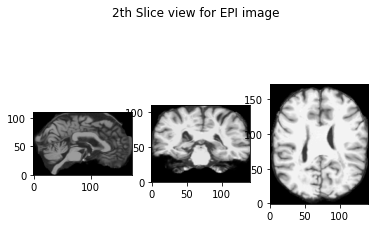

In [25]:
for idx in [168, 181]:
    
    print(dset.data_files[idx])
    viewer = SliceViewer(dset.data_files[idx])
    viewer.triple_view()

## Attention maps from Layer 4

./attention_maps/tmp/layer4/

In [99]:
path = glob('./attention_maps/tmp/layer4/*.nii.gz')

In [100]:
avg_map = nib.load(path[0]).get_fdata()
for att in path[1:]:
    
    avg_map += nib.load(att).get_fdata()
    
avg_map /= len(path)

In [101]:
avg_map.shape

(3, 3, 6)

<AxesSubplot:>

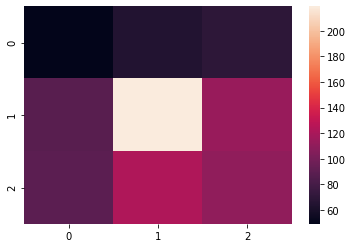

In [102]:
sns.heatmap(avg_map[:, :, 3])